### Анна Тимошенко

In [1]:
import pandas as pd
import pandahouse as ph
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import poisson
import seaborn as sns
import numpy as np

In [3]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20220820',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [17]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-07-13' and '2022-07-19'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

### 1. Выбрать метод анализа и сравнить CTR в двух группах
Далее я применяю последовательно t-тест, тест Манна-Уитни, t-тест на сглаженном ctr (α=5), Пуассоновский бутстреп, а также t-тест и тест Манна-Уитни поверх бакетного преобразования

#### t-test

In [9]:
# t-test
ttest_ind(df[df.exp_group == 1].ctr,
          df[df.exp_group == 2].ctr,
          equal_var=False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

In [19]:
# То же самое с помощью встроенной функции clickhouse
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20220820',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

q = """
WITH welchTTest(ctr, exp_index) as ttest

select tupleElement(ttest,1) as statistic,
    tupleElement(ttest,2) as p_value
FROM (SELECT exp_group, 
        case when exp_group = 1 then 0 else 1 end as exp_index,
        user_id, 
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2022-07-13' and '2022-07-19'
        and exp_group in (1,2)
    GROUP BY exp_group, user_id)
"""
ph.read_clickhouse(q, connection=connection)

,statistic,p_value
0,0.709439,0.478062


t-test показывает, что нет оснований отвергнуть нулевую гипотезу об отсутствии отличий между выборками

#### Тест Манна-Уитни

In [18]:
# Тест Манна-Уитни
print(mannwhitneyu(df[df.exp_group == 1].ctr,
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')
      )

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)


In [20]:
# Тест Манна-Уитни с помощью встроенной функции clickhouse
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20220820',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

q = """
WITH mannWhitneyUTest('two-sided')(ctr, exp_index) as mw

select tupleElement(mw,1) as statistic,
    tupleElement(mw,2) as p_value
FROM (SELECT exp_group, 
        case when exp_group = 1 then 0 else 1 end as exp_index,
        user_id, 
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2022-07-13' and '2022-07-19'
        and exp_group in (1,2)
    GROUP BY exp_group, user_id)
"""
ph.read_clickhouse(q, connection=connection)

,statistic,p_value
0,56601260.5,1.655343e-13


тест Манна-Уитни показывает, что можно отвергнуть нулевую гипотезу об отсутствии отличий между 1 и 2 группами (в отношении CTR)

#### Сглаженный ctr + t-test

In [21]:
def get_smoothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [22]:
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()
group1 = df[df.exp_group == 1].copy()
group1['smoothed_ctr'] = df.apply(
    lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
group2 = df[df.exp_group == 2].copy()
group2['smoothed_ctr'] = df.apply(
    lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

In [23]:
ttest_ind(group1['smoothed_ctr'],
          group2['smoothed_ctr'],
          equal_var=False)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

результат t-testа на сглаженном CTR позволяет отвергнуть нулевую гипотезу об отсутствии отличий (при уровне $\alpha$ = 0.05)

#### Пуассоновский бутстреп

In [39]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

CPU times: user 3.15 s, sys: 864 ms, total: 4.02 s
Wall time: 4.06 s


<AxesSubplot:ylabel='Count'>

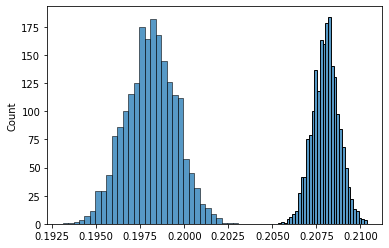

In [42]:
%%time
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)

Визуально результаты пуассоновского бутстрепа говорят о том, что глобальные ctr в группах 1 и 2 отличаются

<AxesSubplot:ylabel='Count'>

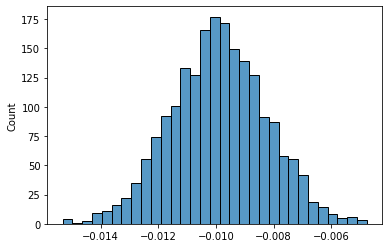

In [43]:
sns.histplot(ctr2 - ctr1)

Гистограмма разности не пересекает ноль, на уровне глобального ctr одна группа строго больше другой

#### t-test и тест Манна-Уитни поверх бакетного преобразования

In [4]:
q = """
SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2022-07-13' and '2022-07-19'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df = ph.read_clickhouse(q, connection=connection)

In [5]:
#тест Манна-Уитни поверх бакетного преобразования
mannwhitneyu(df[df.exp_group == 1].bucket_ctr,
             df[df.exp_group == 2].bucket_ctr,
             alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

In [6]:
# t-test поверх бакетного преобразования
ttest_ind(df[df.exp_group == 1].bucket_ctr, 
          df[df.exp_group == 2].bucket_ctr, 
          equal_var = False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

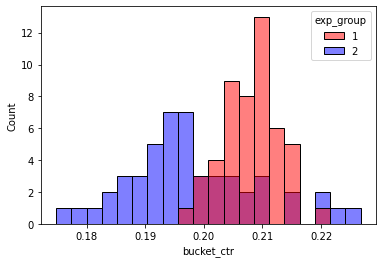

In [14]:
sns.histplot(data=df,
             x='bucket_ctr',
             hue='exp_group',
             palette=['r', 'b'],
             bins = 20
            )

Результаты обоих тестов позволяют отвергнуть нулевую гипотезу об отсутствии различий между группами

In [10]:
#тест Манна-Уитни для оценки разницы 90-х процентилей
mannwhitneyu(df[df.exp_group == 1].ctr9,
             df[df.exp_group == 2].ctr9, 
             alternative = 'two-sided')

MannwhitneyuResult(statistic=0.0, pvalue=6.344839189967265e-18)

<AxesSubplot:xlabel='ctr9', ylabel='Count'>

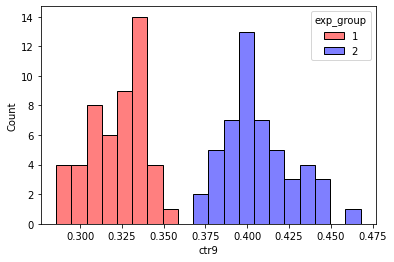

In [15]:
sns.histplot(data=df,
             x='ctr9',
             hue='exp_group',
             palette=['r', 'b'],
             bins=20
            )

t-test применяется только для оценки равенства средних, поэтому для оценки 90-х процентилей поверх бакетного преобразования применяем тест Манна-Уитни. Его результаты показывают наличие отличий между 90%-м квантилем группы 1 и группы 2. Визуально также заметно

### 2. Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали так как сработали?

<AxesSubplot:xlabel='ctr', ylabel='Count'>

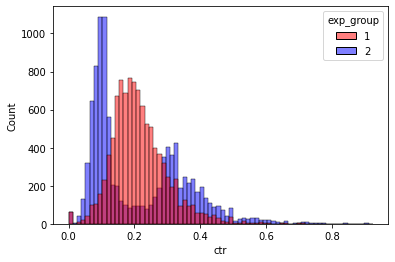

In [7]:
# распределение ctr в группах 1 и 2
sns.histplot(data=df,
             x='ctr',
             hue='exp_group',
             palette=['r', 'b']
            )

<AxesSubplot:xlabel='smoothed_ctr', ylabel='Count'>

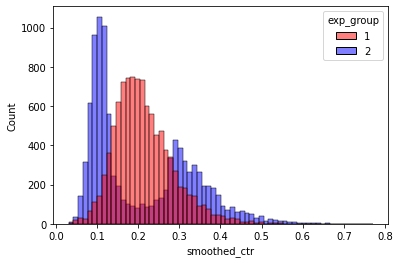

In [32]:
# распределение сглаженных ctr в группах 1 и 2
sns.histplot(data=pd.concat([group1, group2]),
             x='smoothed_ctr',
             hue='exp_group',
             palette=['r', 'b']
            )

Невооруженным глазом видно, что в экспериментальной группе №2 имеет место бимодальное распределение, что прямо указывает на различие групп 1 и 2. Однако t-test, сравнивающий средние, различие "не поймал". Другие тесты указали на различия, т.к. тест Манна-Уитни выявляет различия между ранжированными значениями, а бутстреп более чувствительный (и другие преобразования тоже повышают чувствительность тестов)

### 3. Опишите потенциальную ситуацию, когда такое изменение могло произойти

Раз у нас бимодальное распределение, скорее всего пользователи неоднозначно реагируют на проводимый над ними эксперимент. Как будто получаются две группы - у одних пользователей это приводит к повышению ctr, у других к понижению. Если в данном случае пользователям в группе 2 показывали посты, похожие на те, которые они уже лайкали, соответственно, одни на это реагируют таким образом, что начинают больше лайкать, а другие меньше (может быть проходит эффект новизны - ты лайкнул видео, где котик отпрыгивает от огурца, но следующие видео с подобными котиками и огурцами уже лайкать не интересно, да и смотреть тоже!).

### 4. Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.

По моему мнению, всё-таки не стоит. Хотя 90% квантиль в экспериментальной группе выше, наличие большого количества пользователей с необычно низким ctr в экспериментальной группе (левая вершина распределения) настораживает - всё-таки мы не хотели бы, чтобы наше нововведение  вызывало уменьшение метрики у значительной части пользователей.